In [82]:
import os
import sys
import itertools
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from pytorch_msssim import ssim
import lpips
from tqdm import tqdm
from PIL import Image

from models import *
from utils import *
from helper import *

thirdparty_repo_path = os.path.abspath("/h/lkcai/code/video-perception/DCVC_HEM")
if thirdparty_repo_path not in sys.path:
    sys.path.insert(0, thirdparty_repo_path)

from DCVC_HEM.src.models.video_model import DMC
from DCVC_HEM.src.models.image_model import IntraNoAR
from DCVC_HEM.src.utils.stream_helper import get_state_dict

!nvidia-smi

device = "cuda" if torch.cuda.is_available() else "cpu"

Tue Jan 14 18:03:11 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:2F:00.0 Off |                    0 |
| N/A   44C    P0    28W /  70W |   2911MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [83]:
def load_I_frame_model():
    encoder = Encoder(dim=12, nc=1, stochastic=True, quantize_latents=True, L=2).to(device).eval() 
    decoder_hat = Decoder_Iframe(dim=12).to(device).eval()
    encoder.load_state_dict(torch.load('./I3/I_frame_encoder_zdim_12_L_2.pth'))
    decoder_hat.load_state_dict(torch.load('./I3/I_frame_decoder_zdim_12_L_2.pth'))
    return encoder, decoder_hat

In [84]:
batch_size = 32

train_loader, test_loader = get_dataloader(
    data_root='./data/',
    seq_len=3, 
    batch_size=batch_size, 
    num_digits=1
)

Finished Loading MNIST!


In [89]:
def train_i_one_epoch(i_frame_net, dataloader, optimizer, device, lambd=2., i_q_scale=1.5):
    i_frame_net.train()
    epoch_loss = 0.0
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    
    i_q_scale = i_q_scale
    bitrates = []
    for batch in progress_bar:
        x = batch.to(device).permute(0, 4, 1, 2, 3)
        x0 = x[:, :, 0, :, :]
        
        optimizer.zero_grad()
        
        result = i_frame_net(x0.repeat(1, 3, 1, 1), i_q_scale)
        loss = result["mse"].mean() + lambd * result["bpp"].mean()
        
        bits = result["bit"] / batch_size
        bitrates.append(bits)
        
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item(), bits=bits)
    
    print("Avg bitrates: ", sum(bitrates) / len(bitrates))

    return epoch_loss / len(dataloader)

In [98]:
i_epochs = 5
i_bit_lambd = 10.
i_q_scales = [3.5, ]

for i_q_scale in i_q_scales:
    i_frame_model_path = './DCVC_HEM/checkpoints/acmmm2022_image_ssim.pth.tar'
    i_state_dict = get_state_dict(i_frame_model_path)
    i_frame_net = IntraNoAR()
    i_frame_net.load_state_dict(i_state_dict)
    i_frame_net = i_frame_net.to(device)

    i_optimizer = optim.Adam(i_frame_net.parameters(), lr=1e-4)

    for epoch in range(i_epochs):
        print(f"Epoch {epoch + 1}/{i_epochs}")
        i_train_loss = train_i_one_epoch(
            i_frame_net, train_loader, i_optimizer, device, 
            lambd=i_bit_lambd, i_q_scale=i_q_scale
        )
        print(f"Epoch {epoch + 1} Loss: {i_train_loss:.4f}")

    torch.save(i_frame_net.state_dict(), 
        f"./DCVC_HEM/checkpoints/dcvc-hem_i_bit-lamb-{i_bit_lambd}_scale-{i_q_scale}_ft_epoch_{i_epochs}.pth")

Epoch 1/5


Avg bitrates:  564.0700261067708
Epoch 1 Loss: 5.0182
Epoch 2/5


Avg bitrates:  519.2915182291666
Epoch 2 Loss: 1.2996
Epoch 3/5


Avg bitrates:  509.1047608561198
Epoch 3 Loss: 1.2786
Epoch 4/5


Avg bitrates:  505.1496158528646
Epoch 4 Loss: 1.2711
Epoch 5/5


Avg bitrates:  496.08799431966145
Epoch 5 Loss: 1.2515


In [103]:
def train_v_one_epoch(i_frame_net, video_net, dataloader, optimizer, device, lambd=2., y_q_scale=1.2):
    video_net.train()
    epoch_loss = 0.0
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    
    i_q_scale = 3.5
    mv_y_q_scale = y_q_scale
    y_q_scale = y_q_scale
    
    bitrates = {"x1": [], "x2": []}
    for batch in progress_bar:
        x = batch.to(device).permute(0, 4, 1, 2, 3)
        x0 = x[:, :, 0, :, :]
        x1 = x[:, :, 1, :, :]
        x2 = x[:, :, 2, :, :]
        h, w = x0.shape[2], x0.shape[3]
        
        # hx0 = I_enc(x0)[0]
        # x0_hat = I_dec(hx0).detach().repeat(1, 3, 1, 1)

        optimizer.zero_grad()
        
        x0_result = i_frame_net.encode_decode(
            x0.repeat(1, 3, 1, 1), i_q_scale, None, pic_height=h, pic_width=w)
        dpb = {
            "ref_frame": x0_result["x_hat"].detach(),
            "ref_feature": None,
            "ref_y": None,
            "ref_mv_y": None,
        }

        x1_result = video_net(
            x1.repeat(1, 3, 1, 1), dpb, 
            mv_y_q_scale=mv_y_q_scale, 
            y_q_scale=y_q_scale
        )
        x1_loss = x1_result["mse"].mean() + lambd * x1_result["bpp"].mean()
        
        x2_result = video_net(
            x2.repeat(1, 3, 1, 1), x1_result["dpb"],
            mv_y_q_scale=mv_y_q_scale, 
            y_q_scale=y_q_scale
        )
        x2_loss = x2_result["mse"].mean() + lambd * x2_result["bpp"].mean()
        
        loss = x1_loss + x2_loss
        
        bitrates["x1"].append(x1_result["bit"])
        bitrates["x2"].append(x2_result["bit"])
        
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix(
            loss=loss.item(), x1_loss=x1_loss.item(), x2_loss=x2_loss.item(),
            x1_bit=x1_result["bit"].item(), x2_bit=x2_result["bit"].item())
    
    print(sum(bitrates["x1"]) / len(bitrates["x1"]))
    print(sum(bitrates["x2"]) / len(bitrates["x2"]))

    return epoch_loss / len(dataloader)

In [107]:
v_epochs = 5
v_bit_lambd = 1.
y_q_scale = 1.2

# pretrained quantization scales
# tensor([1.5472, 1.1546, 0.8497, 0.6148])
# tensor([1.2201, 0.9514, 0.7052, 0.5229])
# tensor([1.2290, 1.1469, 1.0580, 0.9737])

i_frame_model_path = './DCVC_HEM/checkpoints/dcvc-hem_i_bit-lamb-5.0_scale-3.5_ft_epoch_5.pth'
i_state_dict = get_state_dict(i_frame_model_path)
i_frame_net = IntraNoAR()
i_frame_net.load_state_dict(i_state_dict)
i_frame_net = i_frame_net.to(device)
i_frame_net.eval()

# video_net
model_path = './DCVC_HEM/checkpoints/acmmm2022_video_ssim.pth.tar'
p_state_dict = get_state_dict(model_path)
video_net = DMC()
video_net.load_state_dict(p_state_dict)
video_net = video_net.to(device)

v_optimizer = optim.Adam(video_net.parameters(), lr=1e-4)

for epoch in range(v_epochs):
    print(f"Epoch {epoch + 1}/{v_epochs}")
    train_loss = train_v_one_epoch(
        i_frame_net, video_net, train_loader, v_optimizer, device, lambd=v_bit_lambd, y_q_scale=y_q_scale)
    print(f"Epoch {epoch + 1} Loss: {train_loss:.4f}")

torch.save(video_net.state_dict(), 
    f"./DCVC_HEM/checkpoints/dcvc-hem_v_bit-lamb-{v_bit_lambd}_scale-{y_q_scale}_ft_epoch_{v_epochs}.pth")

Epoch 1/5


tensor(5994.2456, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3505.2107, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 1 Loss: 0.0883
Epoch 2/5


tensor(5164.0757, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2907.7898, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 2 Loss: 0.0779
Epoch 3/5


tensor(4650.8965, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2513.6367, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 3 Loss: 0.0708
Epoch 4/5


tensor(4420.4370, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2368.2375, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 4 Loss: 0.0681
Epoch 5/5


tensor(4207.6021, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2182.7637, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 5 Loss: 0.0649


NameError: name 'lambd' is not defined

In [108]:
torch.save(video_net.state_dict(), 
    f"./DCVC_HEM/checkpoints/dcvc-hem_v_bit-lamb-{v_bit_lambd}_scale-{y_q_scale}_ft_epoch_{v_epochs}.pth")

[24.155969619750977, 20.863826751708984, 20.469219207763672]


(-0.5, 191.5, 127.5, -0.5)

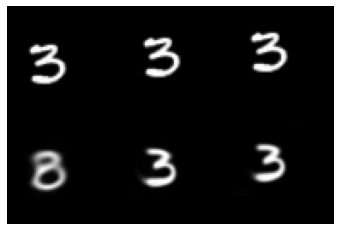

In [115]:
i_frame_model_path = './DCVC_HEM/checkpoints/dcvc-hem_i_bit-lamb-5.0_scale-3.5_ft_epoch_5.pth'

i_state_dict = get_state_dict(i_frame_model_path)
i_frame_net = IntraNoAR()
i_frame_net.load_state_dict(i_state_dict)
i_frame_net = i_frame_net.to(device)
i_frame_net.eval()

model_path = './DCVC_HEM/checkpoints/dcvc-hem_v_bit-lamb-1.0_scale-1.2_ft_epoch_5.pth'

p_state_dict = get_state_dict(model_path)
video_net = DMC()
video_net.load_state_dict(p_state_dict)
video_net = video_net.cuda()
video_net.eval()

x0_path = "/h/lkcai/code/video-perception/reconstructions/R1-eps_1/x1c.png"
x1_path = "/h/lkcai/code/video-perception/reconstructions/R1-eps_1/x2c.png"
x2_path = "/h/lkcai/code/video-perception/reconstructions/R1-eps_1/x3c.png"

x0_hat_path = "/h/lkcai/code/video-perception/reconstructions/R1-eps_1/x1c_hat_12.png"

x0 = Image.open(x0_path)
x0_hat = Image.open(x0_hat_path)
x1 = Image.open(x1_path)
x2 = Image.open(x2_path)

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor()
])

x0 = transform(x0)[0].unsqueeze(0).unsqueeze(0).cuda()
x1 = transform(x1)[0].unsqueeze(0).unsqueeze(0).cuda()
x2 = transform(x2)[0].unsqueeze(0).unsqueeze(0).cuda()
# x0_hat = transform(x0_hat)[0].unsqueeze(0).unsqueeze(0).cuda()

# x0_hat = x0_hat.repeat(1, 3, 1, 1)
x1 = x1.repeat(1, 3, 1, 1)
x2 = x2.repeat(1, 3, 1, 1)

rate_idx = 0
i_frame_q_scale = torch.tensor(4.5)
p_frame_y_q_scale = torch.tensor(3.) # p_frame_y_q_scales[rate_idx]
p_frame_mv_y_q_scale = torch.tensor(3.) # p_frame_y_q_scales[rate_idx]

bits = []
with torch.no_grad():
    h = x0.shape[2]
    w = x0.shape[3]

    bin_path = None

    x0_result = i_frame_net.encode_decode(
        x0.repeat(1, 3, 1, 1), i_frame_q_scale, bin_path, pic_height=h, pic_width=w)
    x0_hat = x0_result['x_hat'].clamp_(0, 1)
    bits.append(x0_result['bit'])
    dpb = {
        "ref_frame": x0_hat,
        "ref_feature": None,
        "ref_y": None,
        "ref_mv_y": None,
    }

    x1_result = video_net.encode_decode(
        x1, dpb, bin_path, pic_height=h, pic_width=w,
        mv_y_q_scale=p_frame_mv_y_q_scale,
        y_q_scale=p_frame_y_q_scale
    )
    dpb = x1_result["dpb"]
    x1_hat = dpb["ref_frame"].clamp_(0, 1)
    bits.append(x1_result['bit'])

    x2_result = video_net.encode_decode(
        x2, dpb, bin_path, pic_height=h, pic_width=w,
        mv_y_q_scale=p_frame_mv_y_q_scale,
        y_q_scale=p_frame_y_q_scale
    )
    dpb = x2_result["dpb"]
    x2_hat = dpb["ref_frame"].clamp_(0, 1)
    bits.append(x2_result['bit'])

print(bits)

x0_hat_dcvc = x0_hat.mean(dim=1)
x1_hat_dcvc = x1_hat.mean(dim=1)
x2_hat_dcvc = x2_hat.mean(dim=1)

x0 = x0.squeeze().cpu().data.numpy()
x1 = x1.squeeze()[1].cpu().data.numpy()
x2 = x2.squeeze()[2].cpu().data.numpy()

x = np.concatenate([x0, x1, x2], axis=1)

x0_hat = x0_hat.squeeze()[0].cpu().data.numpy()
x1_hat_dcvc = x1_hat_dcvc.squeeze().cpu().data.numpy()
x2_hat_dcvc = x2_hat_dcvc.squeeze().cpu().data.numpy()

x_hat_dcvc = np.concatenate([x0_hat, x1_hat_dcvc, x2_hat_dcvc], axis=1)

res_plot = np.concatenate([x, x_hat_dcvc], axis=0)
        
plt.imshow(res_plot, cmap = 'gray')
plt.axis('off')

# plt.imsave(f"./reconstructions/R1-eps_1/x2c_DCVC.png", x1_hat_dcvc, cmap='gray')
# plt.imsave(f"./reconstructions/R1-eps_1/x3c_DCVC.png", x2_hat_dcvc, cmap='gray')